In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import geopandas as gpd
import numpy as np
from geopy.distance import geodesic

import openmeteo_requests
import requests_cache
from retry_requests import retry

# Descargar datos de lluvia Hermosillo 2021-2024

In [11]:
# url de Historical Weather API con las coordenadas de hmo y los rangos de fecha buscados
url = 'https://archive-api.open-meteo.com/v1/archive?latitude=29.1026&longitude=-110.9773&start_date=2021-01-01&end_date=2024-11-10&daily=precipitation_sum&timezone=America%2FDenver&format=csv'

ruta_descarga = os.path.dirname(os.getcwd()) + '/data/raw/precipitacion'

# Realizar la descarga y guardar el archivo
response = requests.get(url)
with open(ruta_descarga, 'wb') as f:
    f.write(response.content)

# Cargar el archivo CSV local
df_lluvia_hmo = pd.read_csv(ruta_descarga)

df_lluvia_hmo

,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,29.06854,-110.975876,214.0,-25200.0,America/Denver,MST
1,time,precipitation_sum (mm),NaN,NaN,NaN,NaN
2,2021-01-01,4.00,NaN,NaN,NaN,NaN
3,2021-01-02,0.00,NaN,NaN,NaN,NaN
4,2021-01-03,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1407,2024-11-06,0.00,NaN,NaN,NaN,NaN
1408,2024-11-07,0.00,NaN,NaN,NaN,NaN
1409,2024-11-08,0.00,NaN,NaN,NaN,NaN
1410,2024-11-09,0.00,NaN,NaN,NaN,NaN


In [12]:
df_lluvia_hmo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               1412 non-null   object 
 1   longitude              1412 non-null   object 
 2   elevation              1 non-null      float64
 3   utc_offset_seconds     1 non-null      float64
 4   timezone               1 non-null      object 
 5   timezone_abbreviation  1 non-null      object 
dtypes: float64(2), object(4)
memory usage: 66.3+ KB


In [13]:
# Quitamos las primeras dos filas inecesarias y reseteamos el indice
df_lluvia_hmo.drop([0, 1], inplace=True)
df_lluvia_hmo.reset_index(drop=True, inplace=True)

# Quitamos columnas mal hechas debido a la estructura
df_lluvia_hmo.drop(['elevation', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation'], axis=1, inplace=True)
# Renombramos adecuadamente las columnas que nos interesan
df_lluvia_hmo.rename(columns={'latitude': 'fecha', 'longitude': 'lluvia'}, inplace=True)
# Quitamos filas con nulos
df_lluvia_hmo.dropna(inplace=True)

# Definimos correctamente los tipos de datos
df_lluvia_hmo['fecha'] = pd.to_datetime(df_lluvia_hmo['fecha'])
df_lluvia_hmo['lluvia'] = df_lluvia_hmo['lluvia'].astype(float)

# Seleccionamos un rango de fechas
df_lluvia_hmo[(df_lluvia_hmo['fecha'] >= '2021-09-01') & (df_lluvia_hmo['fecha'] <= '2024-11-09')].reset_index(drop=True, inplace=True)

df_lluvia_hmo

,fecha,lluvia
0,2021-01-01,4.0
1,2021-01-02,0.0
2,2021-01-03,0.0
3,2021-01-04,0.0
4,2021-01-05,0.0
...,...,...
1405,2024-11-06,0.0
1406,2024-11-07,0.0
1407,2024-11-08,0.0
1408,2024-11-09,0.0


In [14]:
df_lluvia_hmo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   1410 non-null   datetime64[ns]
 1   lluvia  1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB


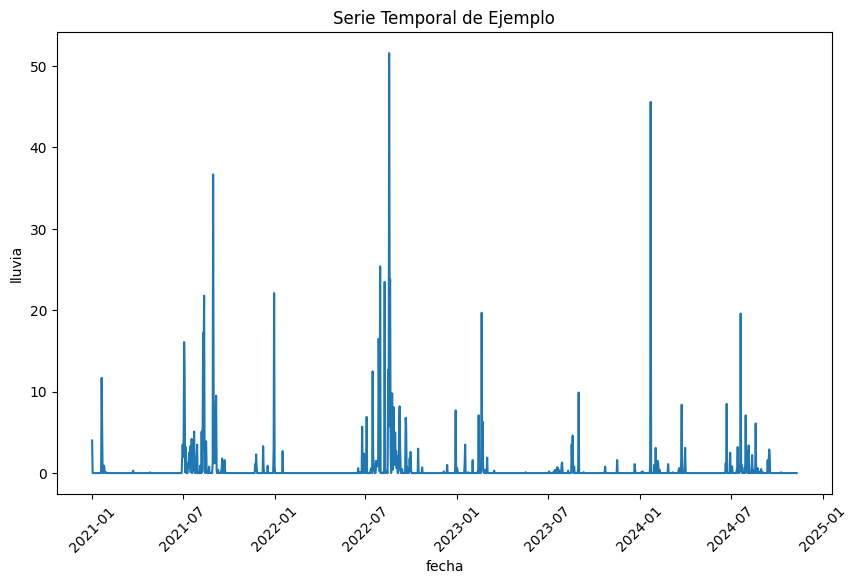

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='fecha', y='lluvia', data=df_lluvia_hmo)
# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.title('Serie Temporal de Ejemplo')
plt.show()

# Descargar datos de precipitacion y baches para nueve zonas

lluvia y zonas

In [16]:
coordenadas_zonas = [(29.109901548511832, -111.02333639953876), (29.124541070577358, -110.99291007309039), (29.14611675223518, -110.97739536308556), 
                     (29.082268147228778, -111.01454901072867), (29.090474375931272, -110.97106699419052), (29.097431318730578, -110.93146365549403),
                     (29.049870596836804, -110.98200537865017), (29.05662334236239, -110.95505454285305), (29.03321193425804, -110.94132163335122)
                     ]

# Crear un diccionario para almacenar las precipitaciones
data = {}

for i, coordenada in enumerate(coordenadas_zonas, start=1):
    url = f'https://archive-api.open-meteo.com/v1/archive?latitude={coordenada[0]}&longitude={coordenada[1]}&start_date=2021-09-01&end_date=2024-11-10&daily=precipitation_sum&timezone=America%2FDenver&format=csv'

    # Descargar el archivo CSV
    response = requests.get(url)
    # Nombramos cada columna por zona
    col_name = f'zona_{i}'
    
    # Guardar el archivo temporalmente
    ruta_descarga = os.path.dirname(os.getcwd()) + f'/data/raw/lluvia_zona_{i}.csv'
    with open(ruta_descarga, 'wb') as f:
        f.write(response.content)

    # Cargar el archivo CSV
    df_lluvia_hmo = pd.read_csv(ruta_descarga)

    # Quitamos las primeras dos filas inecesarias y reseteamos el indice
    df_lluvia_hmo.drop([0, 1], inplace=True)
    df_lluvia_hmo.reset_index(drop=True, inplace=True)

    # Quitamos columnas mal hechas debido a la estructura
    df_lluvia_hmo.drop(['elevation', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation'], axis=1, inplace=True)
    # Renombramos adecuadamente las columnas que nos interesan
    df_lluvia_hmo.rename(columns={'latitude': 'fecha', 'longitude': 'lluvia'}, inplace=True)
    # Quitamos filas con nulos
    df_lluvia_hmo.dropna(inplace=True)

    # Definimos correctamente los tipos de datos
    df_lluvia_hmo['fecha'] = pd.to_datetime(df_lluvia_hmo['fecha'])
    df_lluvia_hmo['lluvia'] = df_lluvia_hmo['lluvia'].astype(float)
    
    # Asignamos la fecha como indice
    df_lluvia_hmo.set_index('fecha', inplace=True)
    
    # Añadir la columna de precipitación de esta zona al diccionario
    data[col_name] = df_lluvia_hmo['lluvia']

# Crear un DataFrame donde cada columna es una zona y los índices son las fechas
df_lluvias = pd.DataFrame(data)


In [17]:
df_lluvias

,zona_1,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,zona_9
fecha,,,,,,,,,
2021-09-01,9.7,9.7,9.7,10.6,10.6,10.6,10.6,10.6,8.0
2021-09-02,1.0,1.0,1.0,1.5,1.5,1.5,1.5,1.5,1.8
2021-09-03,1.6,1.6,1.6,1.2,1.2,1.2,1.2,1.2,2.6
2021-09-04,1.4,1.4,1.4,2.5,2.5,2.5,2.5,2.5,2.3
2021-09-05,7.1,7.1,7.1,7.4,7.4,7.4,7.4,7.4,5.4
...,...,...,...,...,...,...,...,...,...
2024-11-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


baches y zonas

In [18]:
directorio = os.path.dirname(os.getcwd())

In [19]:
baches = gpd.read_file(directorio + '/data/processed/tidy_baches_agebs_hmo.shp')
baches.CVEGEO = baches.CVEGEO.str[-4:]
baches.head()

,latitude,longitude,CVEGEO,date,neighborho,descriptio,geometry
0,29.094161,-110.969471,1996,2021-10-18,[551],"Hay un bache en la calle, y los carros se golp...",POINT (-110.96947 29.09416)
1,29.124060,-110.971318,1746,2021-10-19,[601],"Buen dia! Para reportar pavimento dañado, bach...",POINT (-110.97132 29.12406)
2,29.123985,-110.971286,1746,2021-10-19,[601],"Buen dia! Para reportar pavimento dañado, bach...",POINT (-110.97129 29.12399)
3,29.128777,-110.953926,5043,2021-10-21,[49],toda la calle desde el blvd Morelos tiene vari...,POINT (-110.95393 29.12878)
4,29.083809,-111.042101,2617,2021-10-04,[74],C. SOLICITA BACHEO ASEGURA REPORTANTE QUE ES P...,POINT (-111.0421 29.08381)


In [20]:
df_baches = baches[['date', 'latitude', 'longitude']]
df_baches.rename(columns={'date': 'fecha'}, inplace=True)

# Lista de coordenadas de las zonas, de zona 1 a 9
coordenadas_zonas = [(29.109901548511832, -111.02333639953876), (29.124541070577358, -110.99291007309039), (29.14611675223518, -110.97739536308556), 
                     (29.082268147228778, -111.01454901072867), (29.090474375931272, -110.97106699419052), (29.097431318730578, -110.93146365549403),
                     (29.049870596836804, -110.98200537865017), (29.05662334236239, -110.95505454285305), (29.03321193425804, -110.94132163335122)
                     ]

# Función para encontrar la zona más cercana
def asignar_zona(lat_bache, lon_bache, zonas):
    distancias = [geodesic((lat_bache, lon_bache), (lat_zona, lon_zona)).km for lat_zona, lon_zona in zonas]
    zona_cercana = distancias.index(min(distancias))  # Encuentra la zona más cercana
    return zona_cercana + 1  # Usamos 1-based index (1 a 9) para las zonas

# Aplicar la función a cada reporte de bache
df_baches['zona'] = df_baches.apply(lambda row: asignar_zona(row['latitude'], row['longitude'], coordenadas_zonas), axis=1)

# Mostrar el DataFrame con la zona asignada a cada reporte de bache
print(df_baches)


C:\Users\sbrxb\AppData\Local\Temp\ipykernel_14572\2052706939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baches.rename(columns={'date': 'fecha'}, inplace=True)


           fecha   latitude   longitude  zona
0     2021-10-18  29.094161 -110.969471     5
1     2021-10-19  29.124060 -110.971318     2
2     2021-10-19  29.123985 -110.971286     2
3     2021-10-21  29.128777 -110.953926     3
4     2021-10-04  29.083809 -111.042101     4
...          ...        ...         ...   ...
18828 2024-11-11  29.165260 -111.001808     3
18829 2024-11-11  29.164831 -111.001746     3
18830 2024-11-11  29.065486 -110.989319     7
18831 2024-11-11  29.105208 -110.981033     5
18832 2024-11-11  29.105140 -110.962317     5

[18833 rows x 4 columns]


C:\Users\sbrxb\AppData\Local\Temp\ipykernel_14572\2052706939.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baches['zona'] = df_baches.apply(lambda row: asignar_zona(row['latitude'], row['longitude'], coordenadas_zonas), axis=1)


In [21]:
df_baches.groupby('zona')['zona'].value_counts()

zona
1    1802
2    2800
3    2783
4    1228
5    4602
6    1589
7    1361
8    1314
9    1354
Name: count, dtype: int64

merge de baches y lluvias por zonas

In [22]:
# Unir los dos DataFrames por fecha
df_baches_lluvia = pd.merge(df_baches, df_lluvias, how='left', on='fecha')

df_baches_lluvia.dropna(inplace=True)

# Mostrar las primeras filas del DataFrame resultante
df_baches_lluvia


,fecha,latitude,longitude,zona,zona_1,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,zona_9
0,2021-10-18,29.094161,-110.969471,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-10-19,29.124060,-110.971318,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-10-19,29.123985,-110.971286,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-21,29.128777,-110.953926,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-10-04,29.083809,-111.042101,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18791,2024-11-08,29.143752,-111.019405,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18792,2024-11-08,29.143915,-111.020985,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18793,2024-11-08,29.146711,-111.018076,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18794,2024-11-08,29.144816,-111.019392,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Pruebas Análisis Exploratorio

baches y lluvia

In [23]:
# Definir un umbral de lluvia para considerar un día como lluvioso
umbral_lluvia = 0.1

# Crear una columna de si hubo lluvia (1 para lluvia, 0 para sin lluvia)
df_baches_lluvia['lluvia'] = (df_baches_lluvia[['zona_1', 'zona_2', 'zona_3', 'zona_4', 'zona_5', 'zona_6', 'zona_7', 'zona_8', 'zona_9']].sum(axis=1) > umbral_lluvia).astype(int)

# Verificar los cambios
print(df_baches_lluvia[['fecha', 'lluvia']].drop_duplicates().head())


       fecha  lluvia
0 2021-10-18       0
1 2021-10-19       0
3 2021-10-21       0
4 2021-10-04       0
6 2021-10-25       0


In [24]:
# Función para identificar si el reporte es el día anterior, mismo día o posterior
def dia_relacionado_a_lluvia(fecha, df_lluvias):
    # Buscar si la fecha está cerca de un día lluvioso
    fechas_lluviosas = df_lluvias[df_lluvias['lluvia'] == 1]['fecha']
    
    if fecha in fechas_lluviosas.values:
        return 'Mismo día'
    elif fecha - pd.Timedelta(days=1) in fechas_lluviosas.values:
        return 'Un día después'
    elif fecha + pd.Timedelta(days=1) in fechas_lluviosas.values:
        return 'Un día antes'
    else:
        return 'Otro'

# Aplicar la función para crear la nueva columna
df_baches_lluvia['dia_relacionado_a_lluvia'] = df_baches_lluvia['fecha'].apply(lambda x: dia_relacionado_a_lluvia(x, df_baches_lluvia))

# Ver los primeros resultados
print(df_baches_lluvia[['fecha', 'dia_relacionado_a_lluvia']].head())


       fecha dia_relacionado_a_lluvia
0 2021-10-18                     Otro
1 2021-10-19                     Otro
2 2021-10-19                     Otro
3 2021-10-21                     Otro
4 2021-10-04                     Otro


dia_relacionado_a_lluvia
Mismo día          3555
Otro              12842
Un día antes       1117
Un día después     1282
Name: zona, dtype: int64


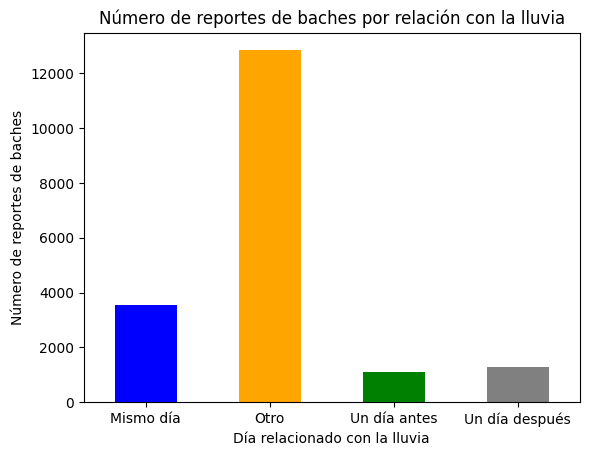

In [25]:
# Contar el número de baches por día relacionado con la lluvia
baches_por_dia_lluvia = df_baches_lluvia.groupby('dia_relacionado_a_lluvia')['zona'].size()

# Mostrar los resultados
print(baches_por_dia_lluvia)

# Crear un gráfico de barras
baches_por_dia_lluvia.plot(kind='bar', color=['blue', 'orange', 'green', 'gray'])
plt.title('Número de reportes de baches por relación con la lluvia')
plt.ylabel('Número de reportes de baches')
plt.xlabel('Día relacionado con la lluvia')
plt.xticks(rotation=0)
plt.show()


dia_relacionado_a_lluvia  Mismo día  Otro  Un día antes  Un día después
zona                                                                   
1                               292  1263           110             132
2                               484  1950           180             183
3                               508  1961           148             161
4                               250   784            87             103
5                               948  3037           285             319
6                               277  1141            78              93
7                               238   963            66              93
8                               266   884            71              90
9                               292   859            92             108


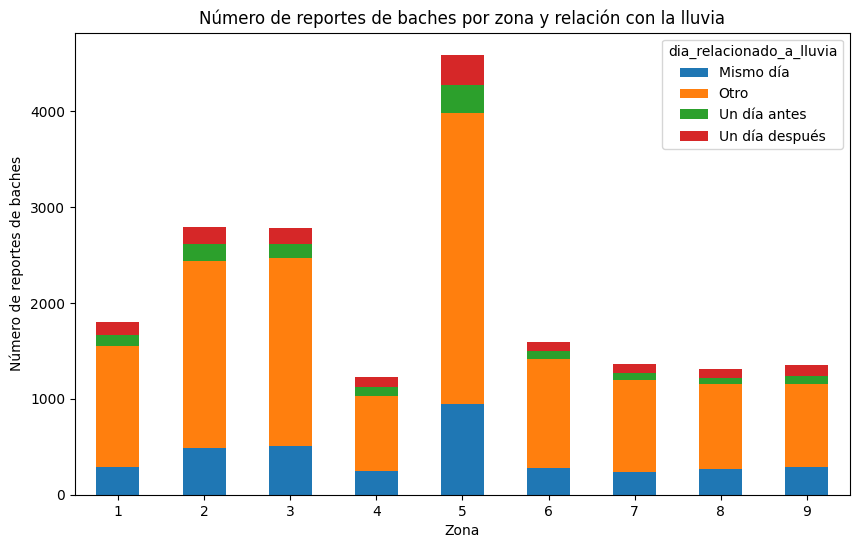

In [26]:
# Agrupar por zona y día relacionado con la lluvia
baches_por_dia_lluvia_zona = df_baches_lluvia.groupby(['zona', 'dia_relacionado_a_lluvia'])['zona'].size().unstack(fill_value=0)

# Mostrar los resultados por zona
print(baches_por_dia_lluvia_zona)

# Crear un gráfico de barras apiladas para cada zona
baches_por_dia_lluvia_zona.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Número de reportes de baches por zona y relación con la lluvia')
plt.ylabel('Número de reportes de baches')
plt.xlabel('Zona')
plt.xticks(rotation=0)
plt.show()


Cantidad de reportes por zona a lo largo del tiempo

In [27]:
# Agrupamos los reportes de baches por fecha y zona, contando la cantidad de reportes por día y zona
df_baches_agrupado = df_baches.groupby(['fecha', 'zona']).size().unstack(fill_value=0)
df_baches_agrupado

zona,1,2,3,4,5,6,7,8,9
fecha,,,,,,,,,
2021-09-17,2,2,0,1,6,2,3,1,1
2021-09-20,0,2,1,1,9,1,2,0,2
2021-09-21,0,7,0,1,13,0,0,2,4
2021-09-22,0,1,0,5,4,0,0,3,0
2021-09-23,1,4,1,5,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...
2024-11-05,1,3,0,1,7,1,3,0,1
2024-11-06,3,7,13,2,13,2,15,1,2
2024-11-07,1,3,3,0,5,0,2,0,1


C:\Users\sbrxb\AppData\Local\Temp\ipykernel_14572\3650932260.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_baches_mensual = df_baches_agrupado.resample('M').sum()


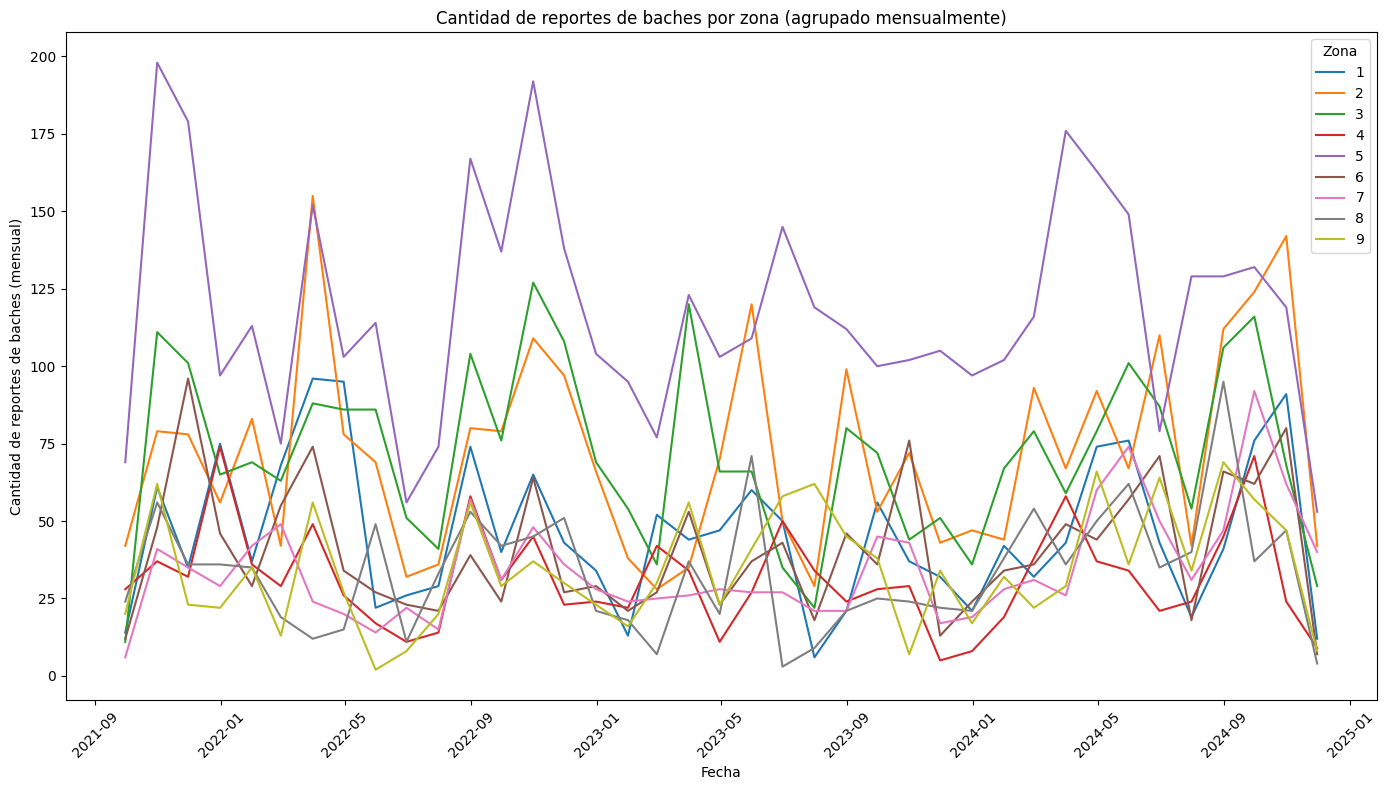

In [28]:
# Agrupamos por mes y calculamos la suma mensual de reportes de baches por zona
df_baches_mensual = df_baches_agrupado.resample('M').sum()

# Graficamos los datos mensuales
plt.figure(figsize=(14, 8))
for zona in df_baches_mensual.columns:
    plt.plot(df_baches_mensual.index, df_baches_mensual[zona], label=zona)

plt.xlabel('Fecha')
plt.ylabel('Cantidad de reportes de baches (mensual)')
plt.title('Cantidad de reportes de baches por zona (agrupado mensualmente)')
plt.legend(title='Zona')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pruebas por temporada

In [29]:
baches_por_fecha = baches.groupby('date',as_index=False).size()

In [38]:
# zona 5 como ejemplo, ya que es la mas centrica
df_lluvia_baches = pd.merge(df_lluvias['zona_5'], baches_por_fecha, left_on='fecha', right_on='date', how='inner')

In [39]:
df_lluvia_baches

,zona_5,date,size
0,0.5,2021-09-17,18
1,0.4,2021-09-20,18
2,0.0,2021-09-21,27
3,0.0,2021-09-22,13
4,1.6,2021-09-23,16
...,...,...,...
840,0.0,2024-11-04,20
841,0.0,2024-11-05,17
842,0.0,2024-11-06,58
843,0.0,2024-11-07,15


In [41]:
# Crear una función para categorizar la temporada de lluvia (julio a septiembre)
def categorizar_temporada(fecha):
    if 7 <= fecha.month <= 9:  
        return 'Temporada de lluvia'
    else:
        return 'Fuera de temporada'

# Aplicar la función al índice 'time' (ya convertido a datetime)
df_lluvia_baches['temporada'] = df_lluvia_baches['date'].apply(categorizar_temporada)

df_lluvia_baches


,zona_5,date,size,temporada
0,0.5,2021-09-17,18,Temporada de lluvia
1,0.4,2021-09-20,18,Temporada de lluvia
2,0.0,2021-09-21,27,Temporada de lluvia
3,0.0,2021-09-22,13,Temporada de lluvia
4,1.6,2021-09-23,16,Temporada de lluvia
...,...,...,...,...
840,0.0,2024-11-04,20,Fuera de temporada
841,0.0,2024-11-05,17,Fuera de temporada
842,0.0,2024-11-06,58,Fuera de temporada
843,0.0,2024-11-07,15,Fuera de temporada


In [42]:
# Calcular el promedio de reportes de baches para cada temporada
promedios_por_temporada = df_lluvia_baches.groupby('temporada')['size'].mean()
print(promedios_por_temporada)


temporada
Fuera de temporada     22.116904
Temporada de lluvia    22.622642
Name: size, dtype: float64


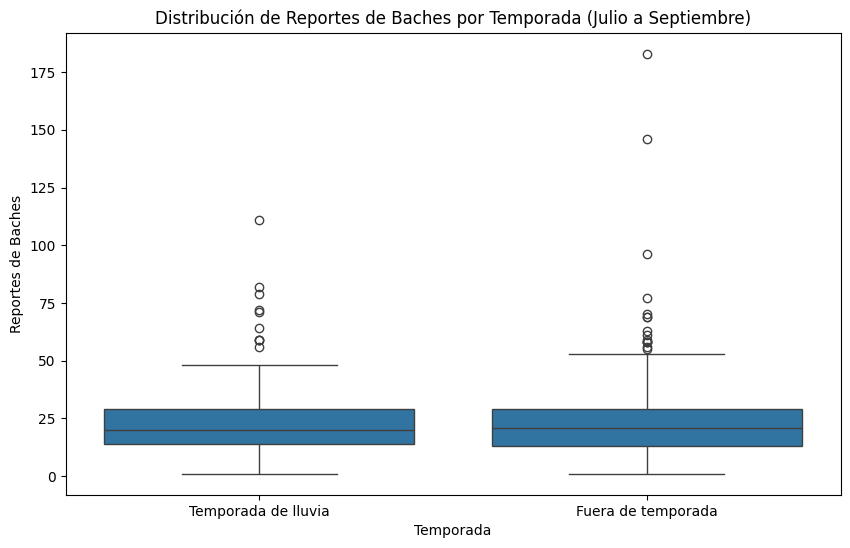

In [43]:
# Crear un boxplot para comparar la distribución de reportes de baches por temporada
plt.figure(figsize=(10, 6))
sns.boxplot(x='temporada', y='size', data=df_lluvia_baches)
plt.title('Distribución de Reportes de Baches por Temporada (Julio a Septiembre)')
plt.xlabel('Temporada')
plt.ylabel('Reportes de Baches')
plt.show()



## Pruebas con categorias de lluvia

In [46]:
# Definir las categorías basadas en los valores de mm de lluvia, incluyendo "Sin lluvia"
def categorizar_lluvia(mm):
    if mm == 0:
        return 'Sin lluvia'
    elif mm <= 2.5:
        return 'Lluvia ligera'
    elif 2.5 < mm <= 7.6:
        return 'Lluvia moderada'
    elif 7.6 < mm <= 50:
        return 'Lluvia fuerte'
    elif 50 < mm <= 100:
        return 'Lluvia muy fuerte'
    else:
        return 'Lluvia extrema'

# Aplicar la función al DataFrame
df_lluvia_baches['categoria_lluvia'] = df_lluvia_baches['zona_5'].apply(categorizar_lluvia)

df_lluvia_baches

,zona_5,date,size,temporada,categoria_lluvia
0,0.5,2021-09-17,18,Temporada de lluvia,Lluvia ligera
1,0.4,2021-09-20,18,Temporada de lluvia,Lluvia ligera
2,0.0,2021-09-21,27,Temporada de lluvia,Sin lluvia
3,0.0,2021-09-22,13,Temporada de lluvia,Sin lluvia
4,1.6,2021-09-23,16,Temporada de lluvia,Lluvia ligera
...,...,...,...,...,...
840,0.0,2024-11-04,20,Fuera de temporada,Sin lluvia
841,0.0,2024-11-05,17,Fuera de temporada,Sin lluvia
842,0.0,2024-11-06,58,Fuera de temporada,Sin lluvia
843,0.0,2024-11-07,15,Fuera de temporada,Sin lluvia


In [47]:
# Contar cuántos días hay en cada categoría
conteo_por_categoria = df_lluvia_baches['categoria_lluvia'].value_counts()

# Calcular el promedio ponderado por la cantidad de días
promedio_ponderado = df_lluvia_baches.groupby('categoria_lluvia').apply(
    lambda x: (x['size'] * 1).sum() / len(x)
)

# Ponderar por el número de días
promedio_ponderado = promedio_ponderado * conteo_por_categoria / conteo_por_categoria.sum()

# Mostrar los resultados ponderados
print(promedio_ponderado)


categoria_lluvia
Lluvia fuerte         0.201183
Lluvia ligera         2.391716
Lluvia moderada       0.648521
Lluvia muy fuerte     0.050888
Sin lluvia           18.951479
dtype: float64


C:\Users\sbrxb\AppData\Local\Temp\ipykernel_14572\2366734780.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  promedio_ponderado = df_lluvia_baches.groupby('categoria_lluvia').apply(


In [48]:
# Contar cuántos días hay en cada categoría
conteo_por_categoria = df_lluvia_baches['categoria_lluvia'].value_counts()

# Mostrar los conteos junto con los promedios
promedios_baches_por_categoria = df_lluvia_baches.groupby('categoria_lluvia')['size'].mean()
resultados_completos = pd.DataFrame({
    'Promedio': promedios_baches_por_categoria,
    'Conteo de días': conteo_por_categoria
})

print(resultados_completos)


                    Promedio  Conteo de días
categoria_lluvia                            
Lluvia fuerte      18.888889               9
Lluvia ligera      20.414141              99
Lluvia moderada    23.826087              23
Lluvia muy fuerte  43.000000               1
Sin lluvia         22.460028             713


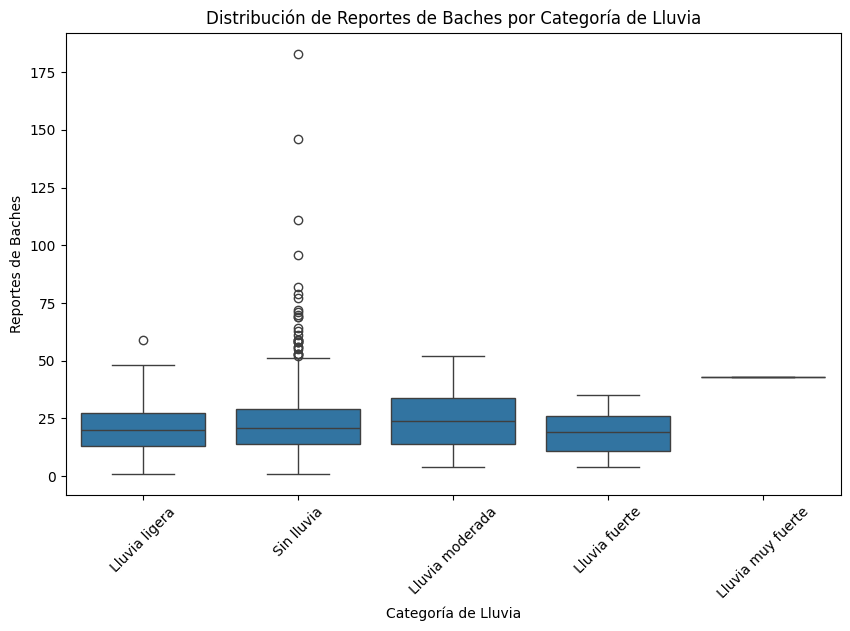

In [50]:
# Crear un boxplot para visualizar la distribución de los reportes de baches en cada categoría
plt.figure(figsize=(10, 6))
sns.boxplot(x='categoria_lluvia', y='size', data=df_lluvia_baches)
plt.title('Distribución de Reportes de Baches por Categoría de Lluvia')
plt.xlabel('Categoría de Lluvia')
plt.ylabel('Reportes de Baches')
plt.xticks(rotation=45)
plt.show()
